# 1. Setup
1.1 Install Dependencies

In [1]:
pip install tensorflow opencv-python matplotlib jupyter_contrib_nbextensions


Note: you may need to restart the kernel to use updated packages.


# 1.2 Import Dependencies

In [1]:
#import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# import tensorflow dependencies - functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Layer, Input, Flatten

# 1.3 Set gpu growth

In [3]:
import tensorflow as tf
import uuid

In [4]:
#set GPU memory consumption in order to avoid OOM(out of memory)
gpus = tf.config.experimental.list_physical_devices('GPU')

In [5]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [8]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

# 2. collecting positive and anchors

2.1

In [ ]:
#Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw',directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

# 2.2 collect Positive and Anchor Classes

In [ ]:
#Establish connection to the webcamera
cap = cv2.VideoCapture(0)
while cap.isOpened():
    #cut down frame to 250x250pxl
    ret , frame = cap.read()
    frame = frame[50:50+250,150:150+250,:]
    
    #collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        #create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out anchor image
        cv2.imwrite(imgname, frame)
    
    #collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        #create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        #write out positive image
        cv2.imwrite(imgname, frame)
       
    #Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    #Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
        
        
# Release the webcam
cap.release()
# Close the image show frame

cv2.destroyAllWindows()
        

# 3. Load and Pre-process Images

# 3.1 Get Images Directoriesa

In [7]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive =tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative =tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [8]:
dir_test = anchor.as_numpy_iterator()

In [9]:
print(dir_test.next())

b'data\\anchor\\8f296372-a8c3-11ee-ab8b-3003c8ac53b6.jpg'


# 3.2 Preprocessing - Scale and Resize

In [10]:
def preprocess(file_path):
    
    #Read in image from file path
    
    byte_img = tf.io.read_file(file_path)
    
    # Load in the image
    
    img = tf.io.decode_jpeg(byte_img)
    
    #pre-processing steps - resizing the image to be 100x100x3
    
    img = tf.image.resize(img, (100, 100))
    
    #scale image to be between 0 and 1
    
    img = img/255.0
    return img
    

In [11]:
img = preprocess('data\\anchor\\e238e34d-a8c3-11ee-a319-3003c8ac53b6.jpg')

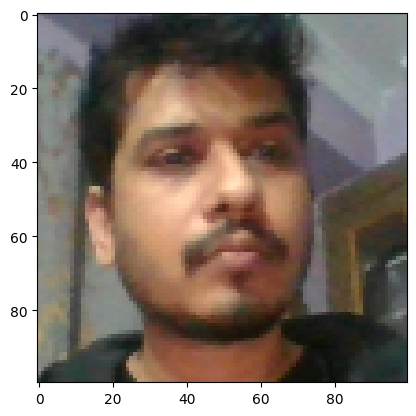

In [12]:
plt.imshow(img)

In [13]:
img.numpy().min()

0.0022058825

# 3.3 Create Labelled Dataset

In [14]:
#(anchor, positive) => 1,1,1,1,1
#(anchor, negative) => 0,0,0,0,0

In [15]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [16]:
samples = data.as_numpy_iterator()

In [17]:
Example = samples.next()

In [18]:
Example

(b'data\\anchor\\7e4a6d47-a8c3-11ee-8410-3003c8ac53b6.jpg',
 b'data\\positive\\494727aa-a8c4-11ee-b702-3003c8ac53b6.jpg',
 1.0)

# 3.4 Build Train  and Test Partition

In [19]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
res = preprocess_twin(*Example)

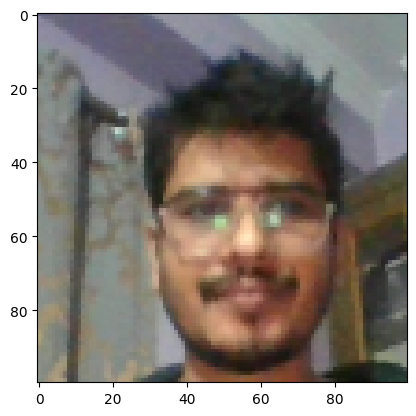

In [26]:
plt.imshow(res[1])

In [21]:
#Build datloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [22]:
# Training pArtition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [23]:
#testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# 4. Model Engineering

# 4.1 Builld Embedding Layer

In [24]:
def make_embedding():
    inp = Input(shape=(100,100,3),   name = 'input_image')
    #first block 
    c1 = Conv2D(64,(10,10), activation = 'relu')(inp)
    m1 = MaxPooling2D(64,(2,2), padding = 'same')(c1)
    
    #second block
    c2 = Conv2D(128,(7,7), activation = 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding = 'same')(c2)
    
    #Third block
    c3 = Conv2D(128,(4,4), activation ='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding ='same')(c3)
    
    #Final embedding block
    c4 = Conv2D(256, (4,4), activation = 'relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation = 'sigmoid')(f1)
    
    
     
    
    return Model(inputs=[inp], outputs=[d1], name ='embedding')
    

In [25]:
embedding = make_embedding()

In [32]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

# 4.2 Build Distance Layer

In [26]:
#Siamese L1 Distance class
class L1Dist(Layer):
    
    #Init method - Inheritance
    def __init__(self, **kwargs):
        super().__init__()
    #MAgic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

# 4.3 Make Siamese Model

In [27]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [28]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [29]:
siamese_layer = L1Dist()

In [30]:
distances = siamese_layer(inp_embedding, val_embedding)

In [32]:
classifier = Dense(1, activation='sigmoid')(distances)

In [33]:

classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [34]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [36]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [37]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    #classificaation layer
    classifier = Dense(1, activation ='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs = classifier, name = 'SiameseNetwork')
    

In [38]:
siamese_model = make_siamese_model()

In [39]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 5. Training

# 5.1 Setup Loss and Optimizer

In [40]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [41]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

# 5.2 Establish Checkpoints

In [42]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join (checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt,siamese_model=siamese_model )

# 5.3 Build Train Step Function

In [43]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        Y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(Y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

In [44]:
test_batch = train_data.as_numpy_iterator()

In [45]:
batch_1 = test_batch.next()

In [46]:
X = batch_1[:2]

In [47]:
Y = batch_1[2]

In [48]:
Y

array([1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 1.],
      dtype=float32)

# 5.4 Build Training Loop

In [49]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

# 5.5 Train the model

In [57]:
EPOCHS = 50

In [58]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
27/27 [==============================] - 13s 400ms/step

 Epoch 2/50
27/27 [==============================] - 10s 381ms/step

 Epoch 3/50
27/27 [==============================] - 10s 375ms/step

 Epoch 4/50
27/27 [==============================] - 10s 368ms/step

 Epoch 5/50
27/27 [==============================] - 10s 367ms/step

 Epoch 6/50
27/27 [==============================] - 10s 366ms/step

 Epoch 7/50
27/27 [==============================] - 10s 368ms/step

 Epoch 8/50
27/27 [==============================] - 10s 367ms/step

 Epoch 9/50
27/27 [==============================] - 10s 368ms/step

 Epoch 10/50
27/27 [==============================] - 10s 367ms/step

 Epoch 11/50
27/27 [==============================] - 10s 369ms/step

 Epoch 12/50
27/27 [==============================] - 10s 367ms/step

 Epoch 13/50
2

# 6. Evaluate Model

# 6.1 Import Metrics

In [59]:
#import metrics calculations
from tensorflow.keras.metrics import Precision, Recall


### 6.2 Make predictions

In [60]:
# get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [61]:
#make predins
y_hat = siamese_model.predict([test_input, test_val])
y_hat 

1/1 [==============================] - 0s 29ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [4.6289904e-07],
       [1.4474145e-09],
       [7.7314093e-09],
       [1.5351252e-07],
       [9.9905199e-01],
       [5.5794185e-06],
       [8.7827633e-14],
       [9.9905938e-01],
       [1.0000000e+00],
       [9.9972409e-01],
       [4.8748479e-12],
       [1.0893340e-05],
       [1.4318939e-10],
       [1.8833921e-10]], dtype=float32)

In [62]:
#post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat]

[1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0]

In [63]:
y_true

array([1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0.],
      dtype=float32)

# 6.3 calculate metrics

In [64]:
# Creating a metric object
m = Recall()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Result Recall Result
m.result().numpy()


1.0

In [65]:
# Creating a metric object
m = Precision()

#Calculating the recall value
m.update_state(y_true, y_hat)

#Result Recall Result
m.result().numpy()

1.0

### 6.4  Viz Results

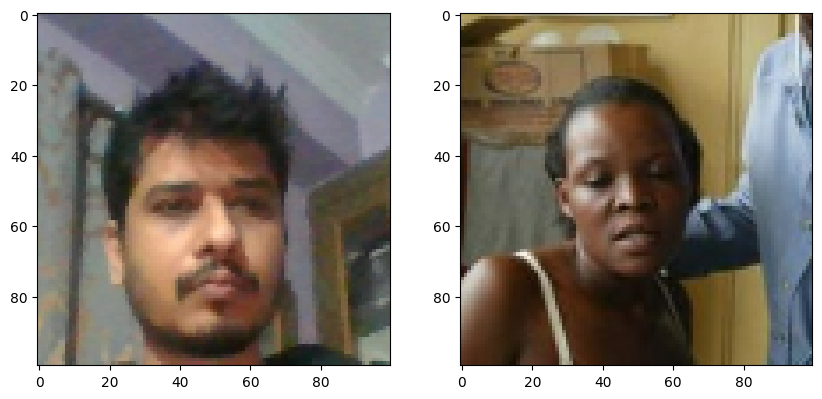

In [66]:
#set plot size
plt.figure( figsize =(10,8))

#set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[2])

#set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[2])

#Renders cleanly
plt.show()

# 7. Save Model

In [118]:
# Save weights
siamese_model.save('siamesemodel.h5')

In [67]:
L1Dist

__main__.L1Dist

In [68]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [69]:
# Make predictions with reloaded model
model.predict([test_input, test_val])

1/1 [==============================] - 0s 107ms/step


array([[9.99999404e-01],
       [9.88364458e-01],
       [7.66156518e-07],
       [1.26942512e-10],
       [1.34531865e-11],
       [1.33632385e-08],
       [9.98673201e-01],
       [3.81382802e-06],
       [1.00401736e-11],
       [9.98481929e-01],
       [9.99999762e-01],
       [9.99565780e-01],
       [2.17401930e-10],
       [7.25593927e-05],
       [1.12959510e-10],
       [8.75987727e-10]], dtype=float32)

In [70]:
# View model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# 8. Real Time Test

## 8.1 Verification Function

In [71]:
os.listdir(os.path.join('application_data','verification_images'))

['33e6382a-a8c4-11ee-9136-3003c8ac53b6.jpg',
 '33eb4ac5-a8c4-11ee-acb8-3003c8ac53b6.jpg',
 '34a76c7b-a8c4-11ee-b579-3003c8ac53b6.jpg',
 '3ad56345-a8c4-11ee-923d-3003c8ac53b6.jpg',
 '3af14c07-a8c4-11ee-8439-3003c8ac53b6.jpg',
 '3af670eb-a8c4-11ee-8e09-3003c8ac53b6.jpg',
 '3afd9c25-a8c4-11ee-9985-3003c8ac53b6.jpg',
 '3b05a1d6-a8c4-11ee-90ad-3003c8ac53b6.jpg',
 '3b0ab706-a8c4-11ee-a568-3003c8ac53b6.jpg',
 '3b0fd15e-a8c4-11ee-86bf-3003c8ac53b6.jpg',
 '3b171da2-a8c4-11ee-943d-3003c8ac53b6.jpg',
 '3b454fd5-a8c4-11ee-b0c8-3003c8ac53b6.jpg',
 '3b5d4624-a8c4-11ee-a5bd-3003c8ac53b6.jpg',
 '3b7aa650-a8c4-11ee-86ec-3003c8ac53b6.jpg',
 '3c017dd2-a8c4-11ee-aa0c-3003c8ac53b6.jpg',
 '3c15c841-a8c4-11ee-babc-3003c8ac53b6.jpg',
 '3c344cd2-a8c4-11ee-b876-3003c8ac53b6.jpg',
 '3c6218cb-a8c4-11ee-ba5b-3003c8ac53b6.jpg',
 '3c672c5a-a8c4-11ee-9fb0-3003c8ac53b6.jpg',
 '3c73a6c6-a8c4-11ee-b0ce-3003c8ac53b6.jpg',
 '3c809f39-a8c4-11ee-9ee4-3003c8ac53b6.jpg',
 '3c85b518-a8c4-11ee-a26b-3003c8ac53b6.jpg',
 '3c9222b4

In [72]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\33e6382a-a8c4-11ee-9136-3003c8ac53b6.jpg
application_data\verification_images\33eb4ac5-a8c4-11ee-acb8-3003c8ac53b6.jpg
application_data\verification_images\34a76c7b-a8c4-11ee-b579-3003c8ac53b6.jpg
application_data\verification_images\3ad56345-a8c4-11ee-923d-3003c8ac53b6.jpg
application_data\verification_images\3af14c07-a8c4-11ee-8439-3003c8ac53b6.jpg
application_data\verification_images\3af670eb-a8c4-11ee-8e09-3003c8ac53b6.jpg
application_data\verification_images\3afd9c25-a8c4-11ee-9985-3003c8ac53b6.jpg
application_data\verification_images\3b05a1d6-a8c4-11ee-90ad-3003c8ac53b6.jpg
application_data\verification_images\3b0ab706-a8c4-11ee-a568-3003c8ac53b6.jpg
application_data\verification_images\3b0fd15e-a8c4-11ee-86bf-3003c8ac53b6.jpg
application_data\verification_images\3b171da2-a8c4-11ee-943d-3003c8ac53b6.jpg
application_data\verification_images\3b454fd5-a8c4-11ee-b0c8-3003c8ac53b6.jpg
application_data\verification_images\3b5d4624-a8c4-11ee-a5bd-300

In [73]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

## 8.2 OpenCV Real Time Verification

In [91]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.5)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 17ms/step
True
1/1 [==============================] - 0s 13ms/step
True
1/1 [==============================] - 0s 17ms/step
True
1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 16ms/step
False
1/1 [==============================] - 0s 6ms/step
False
1/1 [==============================] - 0s 15ms/step
True
1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - 0s 17ms/step
True


In [92]:
np.sum(np.squeeze(results) > 0.9)

27

In [93]:
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [94]:
27/50

0.54